In [228]:
!git clone https://github.com/TaeniKim/nbeats_reproduce.git

fatal: destination path 'nbeats_reproduce' already exists and is not an empty directory.


In [229]:
!pip install neuralforecast

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [230]:
!rm -rf '/content/steps/'

In [231]:
import neuralforecast as nf
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import torch as t
from torch.utils.data import TensorDataset, DataLoader

import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupShuffleSplit

from typing import Tuple
from pathlib import Path

In [232]:
# --------------------------------------- DATA PRE-PROCESSING ---------------------------------------
def add_remaining_useful_life(df):
    # Get the total number of cycles for each unit
    grouped_by_unit = df.groupby(by="unit_nr")
    max_cycle = grouped_by_unit["time_cycles"].max()
    
    # Merge the max cycle back into the original frame
    result_frame = df.merge(max_cycle.to_frame(name='max_cycle'), left_on='unit_nr', right_index=True)
    
    # Calculate remaining useful life for each row
    remaining_useful_life = result_frame["max_cycle"] - result_frame["time_cycles"]
    result_frame["RUL"] = remaining_useful_life
    
    # drop max_cycle as it's no longer needed
    result_frame = result_frame.drop("max_cycle", axis=1)
    return result_frame

def add_operating_condition(df):
    df_op_cond = df.copy()
    
    df_op_cond['setting_1'] = abs(df_op_cond['setting_1'].round())
    df_op_cond['setting_2'] = abs(df_op_cond['setting_2'].round(decimals=2))
    
    # converting settings to string and concatanating makes the operating condition into a categorical variable
    df_op_cond['op_cond'] = df_op_cond['setting_1'].astype(str) + '_' + \
                        df_op_cond['setting_2'].astype(str) + '_' + \
                        df_op_cond['setting_3'].astype(str)
    
    return df_op_cond

def condition_scaler(df_train, df_test, sensor_names):
    # apply operating condition specific scaling
    scaler = StandardScaler()
    for condition in df_train['op_cond'].unique():
        scaler.fit(df_train.loc[df_train['op_cond']==condition, sensor_names])
        df_train.loc[df_train['op_cond']==condition, sensor_names] = scaler.transform(df_train.loc[df_train['op_cond']==condition, sensor_names])
        df_test.loc[df_test['op_cond']==condition, sensor_names] = scaler.transform(df_test.loc[df_test['op_cond']==condition, sensor_names])
    return df_train, df_test

def exponential_smoothing(df, sensors, n_samples, alpha=0.4):
    df = df.copy()
    # first, take the exponential weighted mean
    df[sensors] = df.groupby('unit_nr')[sensors].apply(lambda x: x.ewm(alpha=alpha).mean()).reset_index(level=0, drop=True)
    
    # second, drop first n_samples of each unit_nr to reduce filter delay
    def create_mask(data, samples):
        result = np.ones_like(data)
        result[0:samples] = 0
        return result
    
    mask = df.groupby('unit_nr')['unit_nr'].transform(create_mask, samples=n_samples).astype(bool)
    df = df[mask]
    
    return df

def gen_train_data(df, sequence_length, columns):
    data = df[columns].values
    num_elements = data.shape[0]

    # -1 and +1 because of Python indexing
    for start, stop in zip(range(0, num_elements-(sequence_length-1)), range(sequence_length, num_elements+1)):
        yield data[start:stop, :]
        
def gen_data_wrapper(df, sequence_length, columns, unit_nrs=np.array([])):
    if unit_nrs.size <= 0:
        unit_nrs = df['unit_nr'].unique()
        
    data_gen = (list(gen_train_data(df[df['unit_nr']==unit_nr], sequence_length, columns))
               for unit_nr in unit_nrs)
    data_array = np.concatenate(list(data_gen)).astype(np.float32)
    return data_array

def gen_labels(df, sequence_length, label):
    data_matrix = df[label].values
    num_elements = data_matrix.shape[0]

    # -1 because I want to predict the rul of that last row in the sequence, not the next row
    return data_matrix[sequence_length-1:num_elements, :]  

def gen_label_wrapper(df, sequence_length, label, unit_nrs=np.array([])):
    if unit_nrs.size <= 0:
        unit_nrs = df['unit_nr'].unique()
        
    label_gen = [gen_labels(df[df['unit_nr']==unit_nr], sequence_length, label) 
                for unit_nr in unit_nrs]
    label_array = np.concatenate(label_gen).astype(np.float32)
    return label_array

def gen_test_data(df, sequence_length, columns, mask_value):
    if df.shape[0] < sequence_length:
        data_matrix = np.full(shape=(sequence_length, len(columns)), fill_value=mask_value) # pad
        idx = data_matrix.shape[0] - df.shape[0]
        data_matrix[idx:,:] = df[columns].values  # fill with available data
    else:
        data_matrix = df[columns].values
        
    # specifically yield the last possible sequence
    stop = data_matrix.shape[0]
    start = stop - sequence_length
    for i in list(range(1)):
        yield data_matrix[start:stop, :]  

def get_data(dataset, sensors, sequence_length, alpha, threshold):
	# files
	dir_path = '/content/nbeats_reproduce/datasets/cmapss/'
	train_file = 'train_'+dataset+'.txt'
	test_file = 'test_'+dataset+'.txt'
    # columns
	index_names = ['unit_nr', 'time_cycles']
	setting_names = ['setting_1', 'setting_2', 'setting_3']
	sensor_names = ['s_{}'.format(i+1) for i in range(0,21)]
	col_names = index_names + setting_names + sensor_names
    # data readout
	train = pd.read_csv((dir_path+train_file), sep=r'\s+', header=None, 
					 names=col_names)
	test = pd.read_csv((dir_path+test_file), sep=r'\s+', header=None, 
					 names=col_names)
	y_test = pd.read_csv((dir_path+'RUL_'+dataset+'.txt'), sep=r'\s+', header=None, 
					 names=['RemainingUsefulLife'])

    # create RUL values according to the piece-wise target function
	train = add_remaining_useful_life(train)
	train['RUL'].clip(upper=threshold, inplace=True)

    # remove unused sensors
	drop_sensors = [element for element in sensor_names if element not in sensors]

    # scale with respect to the operating condition
	X_train_pre = add_operating_condition(train.drop(drop_sensors, axis=1))
	X_test_pre = add_operating_condition(test.drop(drop_sensors, axis=1))
	X_train_pre, X_test_pre = condition_scaler(X_train_pre, X_test_pre, sensors)

    # exponential smoothing
	X_train_pre= exponential_smoothing(X_train_pre, sensors, 0, alpha)
	X_test_pre = exponential_smoothing(X_test_pre, sensors, 0, alpha)
    

	# train-val split
	gss = GroupShuffleSplit(n_splits=1, train_size=0.80, random_state=42)
	# generate the train/val for *each* sample -> for that we iterate over the train and val units we want
	# this is a for that iterates only once and in that iterations at the same time iterates over all the values we want,
	# i.e. train_unit and val_unit are not a single value but a set of training/vali units
	for train_unit, val_unit in gss.split(X_train_pre['unit_nr'].unique(), groups=X_train_pre['unit_nr'].unique()): 
		train_unit = X_train_pre['unit_nr'].unique()[train_unit]  # gss returns indexes and index starts at 1
		val_unit = X_train_pre['unit_nr'].unique()[val_unit]

		x_train = gen_data_wrapper(X_train_pre, sequence_length, sensors, train_unit)
		y_train = gen_data_wrapper(X_train_pre, sequence_length, ['RUL'], train_unit)
		
		x_val = gen_data_wrapper(X_train_pre, sequence_length, sensors, val_unit)
		y_val = gen_data_wrapper(X_train_pre, sequence_length, ['RUL'], val_unit)
  
  # create sequences for test 
	x_test_org = X_test_pre
	test_unit = X_test_pre['unit_nr'].unique()
	x_test_index = [len(X_test_pre[X_test_pre.unit_nr == c]) for c in test_unit]
	x_test = gen_data_wrapper(X_test_pre, sequence_length, sensors, test_unit)
    
	#test_gen = (list(gen_test_data(X_test_pre[X_test_pre['unit_nr']==unit_nr], sequence_length, sensors, -99.))
	#		   for unit_nr in X_test_pre['unit_nr'].unique())
	#x_test = np.concatenate(list(test_gen)).astype(np.float32)

	y_test = [list(range(v+sequence_length-1, v-1, -1)) for i, v in enumerate(y_test['RemainingUsefulLife'])]
	y_test = np.array(y_test, dtype='float32')
	y_test = y_test[:,:, np.newaxis]    
    
	return x_train, y_train, x_val, y_val, x_test, y_test, x_test_index, x_test_org

In [233]:
###############################################################################
class NBeatsBlock(t.nn.Module):
    """
    N-BEATS block which takes a basis function as an argument.
    """
    def __init__(self,
                 input_size: int,
                 theta_size: int,
                 basis_function: t.nn.Module,
                 layers: int,
                 layer_size: int):
        """
        N-BEATS block.

        :param input_size: Insample size.
        :param theta_size:  Number of parameters for the basis function.
        :param basis_function: Basis function which takes the parameters and produces backcast and forecast.
        :param layers: Number of layers.
        :param layer_size: Layer size.
        """
        super().__init__()
        self.layers = t.nn.ModuleList([t.nn.Linear(in_features=input_size, out_features=layer_size)] +
                                      [t.nn.Linear(in_features=layer_size, out_features=layer_size)
                                       for _ in range(layers - 1)])
        self.basis_parameters = t.nn.Linear(in_features=layer_size, out_features=theta_size)
        self.basis_function = basis_function

    def forward(self, x: t.Tensor) -> Tuple[t.Tensor, t.Tensor]:
        block_input = x
        for layer in self.layers:
            block_input = t.relu(layer(block_input))
        basis_parameters = self.basis_parameters(block_input)
        return self.basis_function(basis_parameters)


class NBeats(t.nn.Module):
    """
    N-Beats Model.
    """
    def __init__(self, blocks: t.nn.ModuleList):
        super().__init__()
        self.blocks = blocks

    def forward(self, x: t.Tensor, input_mask: t.Tensor) -> t.Tensor:
        residuals = x.flip(dims=(1,)) # left<->right
        input_mask = input_mask.flip(dims=(1,)) # left<->right
        forecast = x[:, -1:]
        for i, block in enumerate(self.blocks):
            backcast, block_forecast = block(residuals)
            residuals = (residuals - backcast) * input_mask
            forecast = forecast + block_forecast
        return forecast
    
    
class GenericBasis(t.nn.Module):
    """
    Generic basis function.
    """
    def __init__(self, backcast_size: int, forecast_size: int):
        super().__init__()
        self.backcast_size = backcast_size
        self.forecast_size = forecast_size

    def forward(self, theta: t.Tensor):
        return theta[:, :self.backcast_size], theta[:, -self.forecast_size:]

In [234]:
def get_corr():
	# files
	dir_path = '/content/nbeats_reproduce/datasets/cmapss/'
	train_file = 'train_FD001.txt'

    # columns
	index_names = ['unit_nr', 'time_cycles']
	setting_names = ['setting_1', 'setting_2', 'setting_3']
	sensor_names = ['s_{}'.format(i+1) for i in range(0,21)]
	col_names = index_names + setting_names + sensor_names
    # data readout
	train = pd.read_csv((dir_path+train_file), sep=r'\s+', header=None, 
					 names=col_names)

	df = train.drop(index_names+setting_names, axis=1)
 
    # create RUL values according to the piece-wise target function
	train = add_remaining_useful_life(train)
	train['RUL'].clip(upper=125, inplace=True)
	
	return train, df.corr()

df, dfc = get_corr()
df.describe()


,unit_nr,time_cycles,setting_1,setting_2,setting_3,s_1,s_2,s_3,s_4,s_5,...,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21,RUL
count,20631.000000,20631.000000,20631.000000,20631.000000,20631.0,2.063100e+04,20631.000000,20631.000000,20631.000000,2.063100e+04,...,20631.000000,20631.000000,20631.000000,2.063100e+04,20631.000000,20631.0,20631.0,20631.000000,20631.000000,20631.000000
mean,51.506568,108.807862,-0.000009,0.000002,100.0,5.186700e+02,642.680934,1590.523119,1408.933782,1.462000e+01,...,2388.096152,8143.752722,8.442146,3.000000e-02,393.210654,2388.0,100.0,38.816271,23.289705,86.829286
std,29.227633,68.880990,0.002187,0.000293,0.0,6.537152e-11,0.500053,6.131150,9.000605,3.394700e-12,...,0.071919,19.076176,0.037505,1.556432e-14,1.548763,0.0,0.0,0.180746,0.108251,41.673699
min,1.000000,1.000000,-0.008700,-0.000600,100.0,5.186700e+02,641.210000,1571.040000,1382.250000,1.462000e+01,...,2387.880000,8099.940000,8.324900,3.000000e-02,388.000000,2388.0,100.0,38.140000,22.894200,0.000000
25%,26.000000,52.000000,-0.001500,-0.000200,100.0,5.186700e+02,642.325000,1586.260000,1402.360000,1.462000e+01,...,2388.040000,8133.245000,8.414900,3.000000e-02,392.000000,2388.0,100.0,38.700000,23.221800,51.000000
50%,52.000000,104.000000,0.000000,0.000000,100.0,5.186700e+02,642.640000,1590.100000,1408.040000,1.462000e+01,...,2388.090000,8140.540000,8.438900,3.000000e-02,393.000000,2388.0,100.0,38.830000,23.297900,103.000000
75%,77.000000,156.000000,0.001500,0.000300,100.0,5.186700e+02,643.000000,1594.380000,1414.555000,1.462000e+01,...,2388.140000,8148.310000,8.465600,3.000000e-02,394.000000,2388.0,100.0,38.950000,23.366800,125.000000
max,100.000000,362.000000,0.008700,0.000600,100.0,5.186700e+02,644.530000,1616.910000,1441.490000,1.462000e+01,...,2388.560000,8293.720000,8.584800,3.000000e-02,400.000000,2388.0,100.0,39.430000,23.618400,125.000000


In [235]:
len(df[df.unit_nr==5])

269

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb876382bd0>,
      dtype=object)

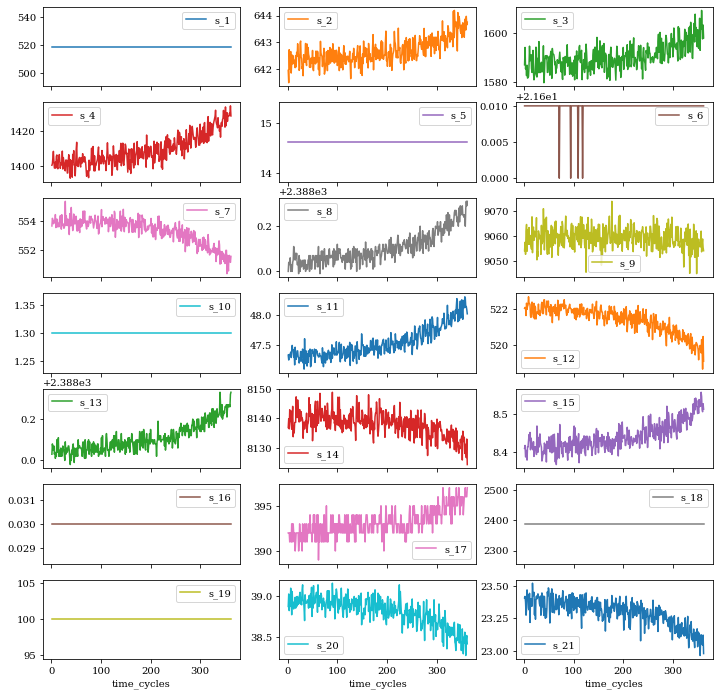

In [236]:
unit_nr = 69
df[df.unit_nr==unit_nr].plot.line(x='time_cycles',
                                  y=['s_{}'.format(i+1) for i in range(0,21)],
                                  subplots=True,
                                  layout=(7,3),
                                  figsize=(12,12),)

In [237]:
dfc = dfc.fillna(0)
dfc.head()

,s_1,s_2,s_3,s_4,s_5,s_6,s_7,s_8,s_9,s_10,...,s_12,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21
s_1,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000
s_2,0.0,1.000000,0.602610,0.714949,0.0,0.132242,-0.702136,0.662325,0.273764,0.0,...,-0.724578,0.661792,0.179752,0.675975,0.0,0.629886,0.0,0.0,-0.661841,-0.668050
s_3,0.0,0.602610,1.000000,0.678413,0.0,0.116039,-0.664595,0.602481,0.322964,0.0,...,-0.680307,0.600963,0.237137,0.639921,0.0,0.600017,0.0,0.0,-0.625941,-0.633901
s_4,0.0,0.714949,0.678413,1.000000,0.0,0.150480,-0.793130,0.746852,0.297429,0.0,...,-0.815591,0.745158,0.190748,0.758459,0.0,0.703499,0.0,0.0,-0.748067,-0.745193
s_5,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000


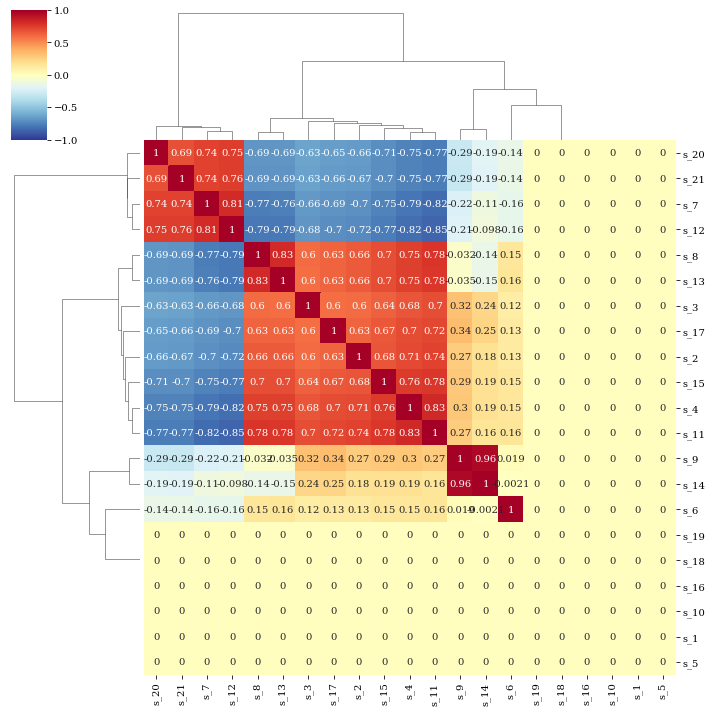

In [238]:
import seaborn as sns

sns.clustermap(dfc,
               annot = True,
               cmap = 'RdYlBu_r',
               vmin = -1, vmax = 1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.


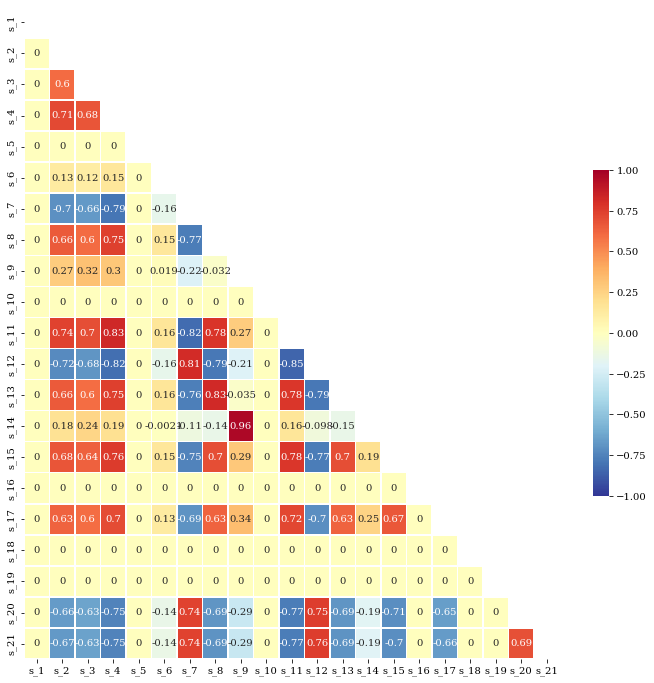

In [239]:
fig, ax = plt.subplots( figsize=(12,12) )

# 삼각형 마스크를 만든다(위 쪽 삼각형에 True, 아래 삼각형에 False)
mask = np.zeros_like(dfc, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# 히트맵을 그린다
sns.heatmap(dfc, 
            cmap = 'RdYlBu_r', 
            annot = True,   # 실제 값을 표시한다
            mask=mask,      # 표시하지 않을 마스크 부분을 지정한다
            linewidths=.5,  # 경계면 실선으로 구분하기
            cbar_kws={"shrink": .5},# 컬러바 크기 절반으로 줄이기
            vmin = -1,vmax = 1   # 컬러바 범위 -1 ~ 1
           )  
plt.show()

# Prepare datasets

In [240]:
## ----------------------------------------------------------------------------
## Prepare - Dataset
dataset = "FD001"
# sensors to work with: T30, T50, P30, PS30, phi
fix_col = ['unit_nr', 'time_cycles']
sensors = ['s_3', 's_4', 's_7', 's_11', 's_12']
#sensors = ['s_4', 's_8', 's_7','s_2', 's_3', 's_15','s_17', 's_20', 's_21']
# windows length
sequence_length = 30
# smoothing intensity
alpha = 0.1
# max RUL
threshold = 125

x_train, y_train, x_valid, y_valid, x_test, y_test, x_test_index, x_test_org = get_data(dataset, sensors, sequence_length, alpha, threshold)

In [241]:
y_train.shape

(14241, 30, 1)

In [242]:
# seperate train dataset
# type1: ------- 수평선
# type2: /////// 열화중
# type3: ---//// 열화시작

from collections import Counter

train_filter = [[i, Counter(list(y_train[i,:,0]))[125.0]] for i in range(y_train.shape[0])]
train_filter1 = []
train_filter2 = []
train_filter3 = []
for i, c in train_filter:    
    if c == 30: # 수평선
        train_filter1.append(i)
    elif c == 0: # 열화중
        train_filter2.append(i)
    else: # 열화 시작
        train_filter3.append(i)

print(f'train - type1:{len(train_filter1)}, type2:{len(train_filter2)}, type3:{len(train_filter3)}')

valid_filter = [[i, Counter(list(y_valid[i,:,0]))[125.0]] for i in range(y_valid.shape[0])]
valid_filter1 = []
valid_filter2 = []
valid_filter3 = []
for i, c in valid_filter:    
    if c == 30: # 수평선
        valid_filter1.append(i)
    elif c == 0: # 열화중
        valid_filter2.append(i)
    else: # 열화 시작
        valid_filter3.append(i)

print(f'train - type1:{len(valid_filter1)}, type2:{len(valid_filter2)}, type3:{len(valid_filter3)}')

train - type1:4320, type2:7680, type3:2241
train - type1:1009, type2:1920, type3:561


In [243]:
x_train_f1 = np.take(x_train, train_filter1, axis=0)
x_train_f2 = np.take(x_train, train_filter2, axis=0)
x_train_f3 = np.take(x_train, train_filter3, axis=0)

y_train_f1 = np.take(y_train, train_filter1, axis=0)
y_train_f2 = np.take(y_train, train_filter2, axis=0)
y_train_f3 = np.take(y_train, train_filter3, axis=0)

x_valid_f1 = np.take(x_valid, valid_filter1, axis=0)
x_valid_f2 = np.take(x_valid, valid_filter2, axis=0)
x_valid_f3 = np.take(x_valid, valid_filter3, axis=0)

y_valid_f1 = np.take(y_valid, valid_filter1, axis=0)
y_valid_f2 = np.take(y_valid, valid_filter2, axis=0)
y_valid_f3 = np.take(y_valid, valid_filter3, axis=0)

In [244]:
import copy

def to_tensor(array: np.ndarray) -> t.Tensor:
        """
        Convert numpy array to tensor on default device.
    
        :param array: Numpy array to convert.
        :return: PyTorch tensor on default device.
        """
        return t.tensor(array, dtype=t.float32).to(default_device)


In [245]:
x_test_re = x_test.reshape(x_test.shape[0], x_test.shape[1]*x_test.shape[2])
y_test_re = y_test.reshape(y_test.shape[0], y_test.shape[1]*y_test.shape[2])

x_test_index_re = [(v - window_size +1) for v in x_test_index]
x_test_index_re2 = []
buf = 0
for i, v in enumerate(x_test_index_re):
    if i==0:
        x_test_index_re2.append([0, x_test_index_re[0]])
        buf =  x_test_index_re[0]
        continue
    buf += x_test_index_re[i]
    x_test_index_re2.append([x_test_index_re2[i-1][1], buf])
x_test_index_re2[:5]

[[0, 2], [2, 22], [22, 119], [119, 196], [196, 265]]

In [246]:
def plot_unit(unit_no, forecasts):
    t_len = x_test[unit_no-1] - window_size + 1 # sample length
    s_idx = x_test_index_re2[unit_no-1][0]
    e_idx = x_test_index_re2[unit_no-1][1]

    df = pd.DataFrame([v[-1] for v in forecasts[s_idx:e_idx]], columns=['y_hat'])

    tt = np.arange(y_test[:][:][unit_no-1][window_size-1], y_test[:][:][unit_no-1][window_size-1] + len(df.y_hat))
    tt = np.flip(tt)
    test = lambda v:threshold if v>threshold else v
    df['y'] = pd.DataFrame([test(v) for v in tt], columns=['y']) 

    fig, ax1 = plt.subplots(figsize=(5, 7))

    ax1.set_xlabel('Time cycles(#)')
    ax1.set_ylabel('RUL')
    ax1.set_ylim([0, threshold+15])
    ax1.plot(df['y_hat'], color='red', label='y_hat')
    ax1.plot(df['y'], color='blue', label='y')
    ax1.legend()

    fig.tight_layout()
    plt.title('unit #' + str(unit_no))
    plt.show()

In [247]:
from sklearn.metrics import mean_squared_error, r2_score

def evaluate(y_true, y_hat, label='test'):
    mse = mean_squared_error(y_true, y_hat)
    rmse = np.sqrt(mse)
    variance = r2_score(y_true, y_hat)
    print('{} set RMSE:{:.3f}, R2:{:.3f}'.format(label, rmse, variance))

    return rmse, variance

def score(y_true, y_hat):
  res = 0
  for true, hat in zip(y_true, y_hat):
    subs = hat - true
    #print(subs)
    if subs < 0:
      res = res + np.exp(-subs/13)-1
    else:
      res = res + np.exp(subs/10)-1
  print("score: {:.3f}".format(res))

  return res

# Type1 modeling: 정상 - All(30) threshold

In [248]:
# type1 modeling
x_train = x_train_f1
y_train = y_train_f1
x_valid = x_valid_f1
y_valid = y_valid_f1

In [249]:
x_train_re = x_train.reshape(x_train.shape[0], x_train.shape[1]*x_train.shape[2])
y_train_re = y_train.reshape(y_train.shape[0], y_train.shape[1]*y_train.shape[2])
x_valid_re = x_valid.reshape(x_valid.shape[0], x_valid.shape[1]*x_valid.shape[2])
y_valid_re = y_valid.reshape(y_valid.shape[0], y_valid.shape[1]*y_valid.shape[2])
x_train_re.shape

(4320, 150)

In [250]:
## ----------------------------------------------------------------------------
## Make model
window_size = sequence_length
input_dim = len(sensors)
output_dim = 1 # RUL

timeseries = x_train
batch_size = 512
insample_size = window_size * input_dim # 30 * 5
outsample_size = window_size * output_dim # 30 * 1
theta_size = insample_size + outsample_size
stacks = 3
layers = 4
layer_size = 1024
early_stop = 10


model = NBeats(t.nn.ModuleList([NBeatsBlock(input_size=insample_size,
                                            theta_size=theta_size,
                                            basis_function=GenericBasis(backcast_size = insample_size,
                                                                        forecast_size = outsample_size),
                                            layers=layers,
                                            layer_size=layer_size)
                                for _ in range(stacks)]))


default_device = t.device('cuda' if t.cuda.is_available() else 'cpu')
model = model.to(default_device)

learning_rate = 0.00001
optimizer = t.optim.Adam(model.parameters(), lr=learning_rate)
training_loss_fn = t.nn.MSELoss()
iterations = 10000
lr_decay_step = iterations // 3            
if lr_decay_step == 0:
    lr_decay_step = 1

In [251]:
# standby dataset
train_dataset = TensorDataset(t.Tensor(x_train_re), t.Tensor(y_train_re))
train_dataloader =  DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

valid_dataset = TensorDataset(t.Tensor(x_valid_re), t.Tensor(y_valid_re))
valid_dataloader =  DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)

his_train = []
min_valid_loss = 99999
cnt_valid_loss = 0
for i in range(1, iterations + 1):
    # Sampling
    x_train_sampled, y_train_sampled = next(iter(train_dataloader))

    # train
    model.train()
    x = x_train_sampled
    x_mask = np.ones(shape=x.shape, dtype=np.float32)
    y = y_train_sampled
    y_mask = np.ones(shape=y.shape, dtype=np.float32)    
    
    x, x_mask, y, y_mask = map(to_tensor, (x, x_mask, y, y_mask))

    optimizer.zero_grad() # init gradients before back-propagation
    forecast = model(x, x_mask)
    training_loss = training_loss_fn(forecast, y)

    if np.isnan(float(training_loss)):
        break

    training_loss.backward()
    t.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    optimizer.step()

    for param_group in optimizer.param_groups:
        param_group["lr"] = learning_rate * 0.5 ** (i // lr_decay_step)

    def check_directorys(f: str) -> None:
        if not Path(f).is_dir():
            print(f"create directory: {f.split(sep='/')[-1]}")
            Path(f).mkdir(parents=True, exist_ok=True)
            

    if i % 100 == 1:
        # Sampling
        x_valid_sampled, y_valid_sampled = next(iter(valid_dataloader))

        # valid
        model.eval()
        x = x_valid_sampled
        x_mask = np.ones(shape=x.shape, dtype=np.float32)
        y = y_valid_sampled
        y_mask = np.ones(shape=y.shape, dtype=np.float32)   

        x, x_mask, y, y_mask = map(to_tensor, (x, x_mask, y, y_mask))

        forecast = model(x, x_mask)
        valid_loss = training_loss_fn(forecast, y)

        f = r'./steps/' + dataset + r'/'
        check_directorys(f)
        f += f'weight_iter_{i:05d}.pth'
        print('Save Model:', f)
        t.save(model, f)
        print(f'iter:{i}/{iterations} \t train_loss:{training_loss:.3f} \t val_loss:{valid_loss:.3f}') 
        his_train.append([i, training_loss, valid_loss])

        if valid_loss < min_valid_loss:
            min_valid_loss = valid_loss
            cnt_valid_loss = 0
            best_model = copy.deepcopy(model)
        else:
            cnt_valid_loss += 1

        if cnt_valid_loss >= early_stop:
            print('Early stop..!!')
            print('Save Best Model')
            t.save(best_model, r'./steps/' + dataset + r'/best_weight.pth')
            break

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.


create directory: 
Save Model: ./steps/FD001/weight_iter_00001.pth
iter:1/10000 	 train_loss:15471.900 	 val_loss:15436.303
Save Model: ./steps/FD001/weight_iter_00101.pth
iter:101/10000 	 train_loss:15033.847 	 val_loss:14913.327
Save Model: ./steps/FD001/weight_iter_00201.pth
iter:201/10000 	 train_loss:4553.730 	 val_loss:3983.054
Save Model: ./steps/FD001/weight_iter_00301.pth
iter:301/10000 	 train_loss:1394.146 	 val_loss:949.231
Save Model: ./steps/FD001/weight_iter_00401.pth
iter:401/10000 	 train_loss:104.016 	 val_loss:73.793
Save Model: ./steps/FD001/weight_iter_00501.pth
iter:501/10000 	 train_loss:24.653 	 val_loss:37.399
Save Model: ./steps/FD001/weight_iter_00601.pth
iter:601/10000 	 train_loss:14.574 	 val_loss:27.770
Save Model: ./steps/FD001/weight_iter_00701.pth
iter:701/10000 	 train_loss:12.004 	 val_loss:20.787
Save Model: ./steps/FD001/weight_iter_00801.pth
iter:801/10000 	 train_loss:9.690 	 val_loss:17.218
Save Model: ./steps/FD001/weight_iter_00901.pth
iter:90

In [252]:
# Evaluate
x_mask = np.ones(shape=x_test_re.shape, dtype=np.float32)
x, x_mask = map(to_tensor, (x_test_re, x_mask))

model = best_model
model.eval()
forecasts = []
with t.no_grad():
    forecasts.extend(model(x, x_mask).cpu().detach().numpy())   

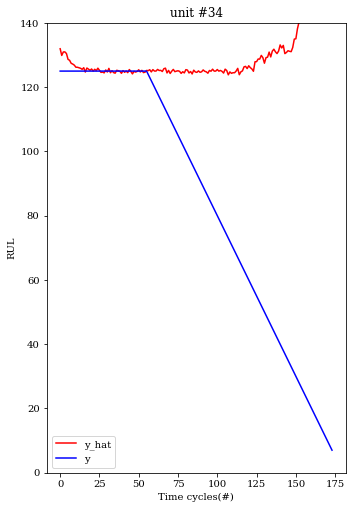

In [253]:
plot_unit(unit_no = 34, forecasts = forecasts)

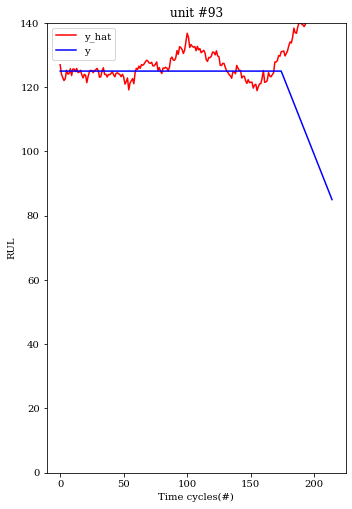

In [254]:
plot_unit(unit_no = 93, forecasts = forecasts)

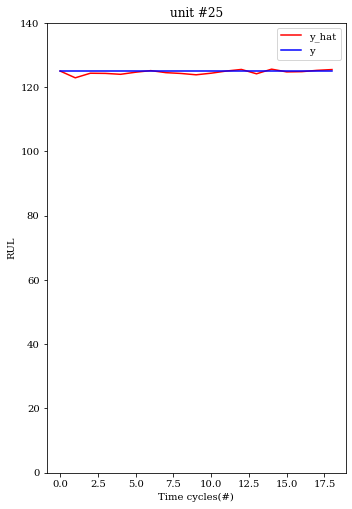

In [255]:
plot_unit(unit_no = 25, forecasts = forecasts)

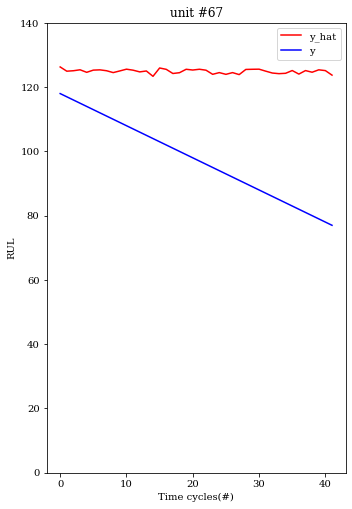

In [256]:
plot_unit(unit_no = 67, forecasts = forecasts)

In [257]:
lst_y_true=[]
lst_y_hat=[]
for u in range(1, 101):   
    idx = x_test_index_re2[u-1][1]-1
    test = lambda v:threshold if v>threshold else v

    lst_y_true.append(int(test(y_test[:][:][u-1][window_size-1])))
    lst_y_hat.append(forecasts[idx][window_size-1])

In [258]:
rmse, var = evaluate(lst_y_true, lst_y_hat)
res = score(lst_y_true, lst_y_hat)

test set RMSE:96.227, R2:-4.766
score: 115988923790.234


In [259]:
df1 = pd.DataFrame(lst_y_true, columns=['y'])
df1['y_hat'] = pd.DataFrame(lst_y_hat)
df1['y_real'] = pd.DataFrame([int(x[-1]) for x in y_test])
df1 = df1.sort_values(by=['y_real']).reset_index()

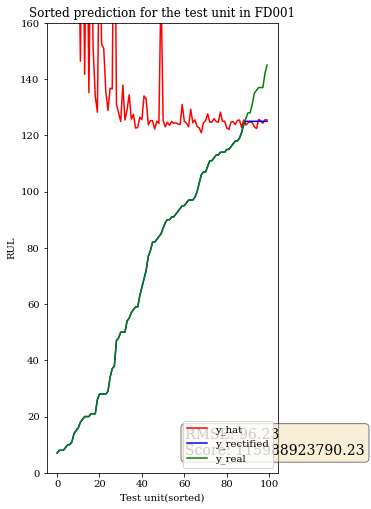

In [260]:
textstr = '\n'.join((    
    r'RMSE: %.2f' % (rmse, ),
    r'Score: %.2f' % (res, )))

# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

fig, ax1 = plt.subplots(figsize=(5, 7))

ax1.set_xlabel('Test unit(sorted)')
ax1.set_ylabel('RUL')
ax1.set_ylim([0, 160])
ax1.plot(df1['y_hat'], color='red', label='y_hat')
ax1.plot(df1['y'], color='blue', label='y_rectified')
ax1.plot(df1['y_real'], color='green', label='y_real')
ax1.legend()
ax1.text(0.60, 0.1, textstr, transform=ax1.transAxes, fontsize=14, verticalalignment='top', bbox=props)

fig.tight_layout()
plt.title('Sorted prediction for the test unit in ' + dataset)
plt.show()

In [261]:
df_type = df1

# Type2 Modeling: 열화중 - None(0) threshold

In [262]:
# type2 modeling
x_train = x_train_f2
y_train = y_train_f2
x_valid = x_valid_f2
y_valid = y_valid_f2

In [263]:
x_train_re = x_train.reshape(x_train.shape[0], x_train.shape[1]*x_train.shape[2])
y_train_re = y_train.reshape(y_train.shape[0], y_train.shape[1]*y_train.shape[2])
x_valid_re = x_valid.reshape(x_valid.shape[0], x_valid.shape[1]*x_valid.shape[2])
y_valid_re = y_valid.reshape(y_valid.shape[0], y_valid.shape[1]*y_valid.shape[2])
x_train_re.shape

(7680, 150)

In [264]:
## ----------------------------------------------------------------------------
## Make model
window_size = sequence_length
input_dim = len(sensors)
output_dim = 1 # RUL

timeseries = x_train
batch_size = 512
insample_size = window_size * input_dim # 30 * 5
outsample_size = window_size * output_dim # 30 * 1
theta_size = insample_size + outsample_size
stacks = 3
layers = 4
layer_size = 1024
early_stop = 10


model = NBeats(t.nn.ModuleList([NBeatsBlock(input_size=insample_size,
                                            theta_size=theta_size,
                                            basis_function=GenericBasis(backcast_size = insample_size,
                                                                        forecast_size = outsample_size),
                                            layers=layers,
                                            layer_size=layer_size)
                                for _ in range(stacks)]))


default_device = t.device('cuda' if t.cuda.is_available() else 'cpu')
model = model.to(default_device)

learning_rate = 0.00001
optimizer = t.optim.Adam(model.parameters(), lr=learning_rate)
training_loss_fn = t.nn.MSELoss()
iterations = 10000
lr_decay_step = iterations // 3            
if lr_decay_step == 0:
    lr_decay_step = 1

In [265]:
# standby dataset
train_dataset = TensorDataset(t.Tensor(x_train_re), t.Tensor(y_train_re))
train_dataloader =  DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

valid_dataset = TensorDataset(t.Tensor(x_valid_re), t.Tensor(y_valid_re))
valid_dataloader =  DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)

his_train = []
min_valid_loss = 99999
cnt_valid_loss = 0
for i in range(1, iterations + 1):
    # Sampling
    x_train_sampled, y_train_sampled = next(iter(train_dataloader))

    # train
    model.train()
    x = x_train_sampled
    x_mask = np.ones(shape=x.shape, dtype=np.float32)
    y = y_train_sampled
    y_mask = np.ones(shape=y.shape, dtype=np.float32)    
    
    x, x_mask, y, y_mask = map(to_tensor, (x, x_mask, y, y_mask))

    optimizer.zero_grad() # init gradients before back-propagation
    forecast = model(x, x_mask)
    training_loss = training_loss_fn(forecast, y)

    if np.isnan(float(training_loss)):
        break

    training_loss.backward()
    t.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    optimizer.step()

    for param_group in optimizer.param_groups:
        param_group["lr"] = learning_rate * 0.5 ** (i // lr_decay_step)

    def check_directorys(f: str) -> None:
        if not Path(f).is_dir():
            print(f"create directory: {f.split(sep='/')[-1]}")
            Path(f).mkdir(parents=True, exist_ok=True)
            

    if i % 100 == 1:
        # Sampling
        x_valid_sampled, y_valid_sampled = next(iter(valid_dataloader))

        # valid
        model.eval()
        x = x_valid_sampled
        x_mask = np.ones(shape=x.shape, dtype=np.float32)
        y = y_valid_sampled
        y_mask = np.ones(shape=y.shape, dtype=np.float32)   

        x, x_mask, y, y_mask = map(to_tensor, (x, x_mask, y, y_mask))

        forecast = model(x, x_mask)
        valid_loss = training_loss_fn(forecast, y)

        f = r'./steps/' + dataset + r'/'
        check_directorys(f)
        f += f'weight_iter_{i:05d}.pth'
        print('Save Model:', f)
        t.save(model, f)
        print(f'iter:{i}/{iterations} \t train_loss:{training_loss:.3f} \t val_loss:{valid_loss:.3f}') 
        his_train.append([i, training_loss, valid_loss])

        if valid_loss < min_valid_loss:
            min_valid_loss = valid_loss
            cnt_valid_loss = 0
            best_model = copy.deepcopy(model)
        else:
            cnt_valid_loss += 1

        if cnt_valid_loss >= early_stop:
            print('Early stop..!!')
            print('Save Best Model')
            t.save(best_model, r'./steps/' + dataset + r'/best_weight.pth')
            break

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.


Save Model: ./steps/FD001/weight_iter_00001.pth
iter:1/10000 	 train_loss:4910.715 	 val_loss:4637.192
Save Model: ./steps/FD001/weight_iter_00101.pth
iter:101/10000 	 train_loss:4458.752 	 val_loss:4572.583
Save Model: ./steps/FD001/weight_iter_00201.pth
iter:201/10000 	 train_loss:1762.792 	 val_loss:1900.265
Save Model: ./steps/FD001/weight_iter_00301.pth
iter:301/10000 	 train_loss:1022.410 	 val_loss:1031.812
Save Model: ./steps/FD001/weight_iter_00401.pth
iter:401/10000 	 train_loss:181.670 	 val_loss:160.200
Save Model: ./steps/FD001/weight_iter_00501.pth
iter:501/10000 	 train_loss:100.744 	 val_loss:117.432
Save Model: ./steps/FD001/weight_iter_00601.pth
iter:601/10000 	 train_loss:93.438 	 val_loss:117.385
Save Model: ./steps/FD001/weight_iter_00701.pth
iter:701/10000 	 train_loss:87.883 	 val_loss:109.173
Save Model: ./steps/FD001/weight_iter_00801.pth
iter:801/10000 	 train_loss:84.527 	 val_loss:111.630
Save Model: ./steps/FD001/weight_iter_00901.pth
iter:901/10000 	 train

In [266]:
# Evaluate
x_mask = np.ones(shape=x_test_re.shape, dtype=np.float32)
x, x_mask = map(to_tensor, (x_test_re, x_mask))

model = best_model
model.eval()
forecasts = []
with t.no_grad():
    forecasts.extend(model(x, x_mask).cpu().detach().numpy())   

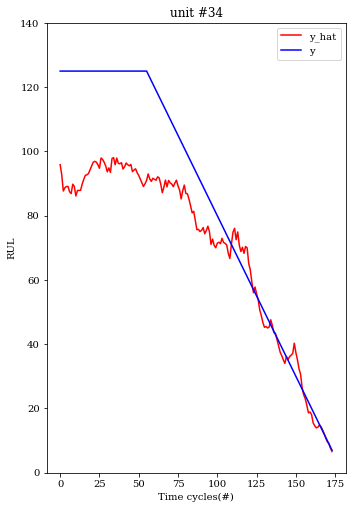

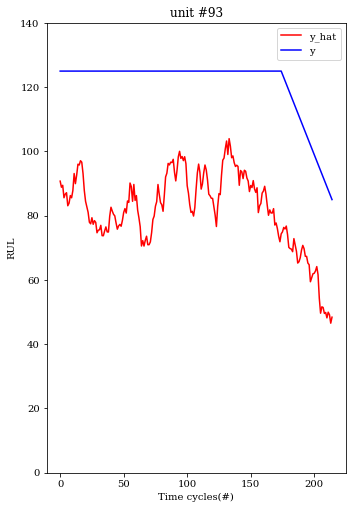

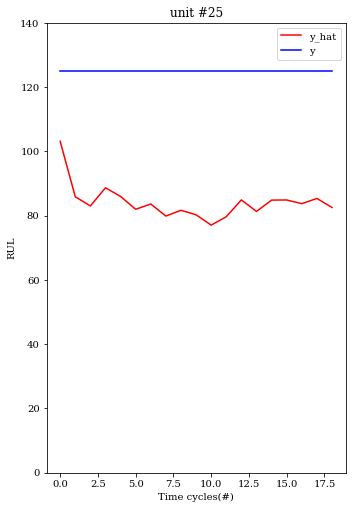

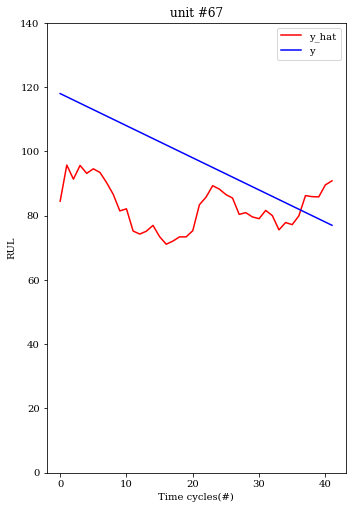

In [267]:
for n in [34, 93, 25, 67]:
    plot_unit(unit_no = n, forecasts = forecasts)

In [268]:
lst_y_true=[]
lst_y_hat=[]
for u in range(1, 101):   
    idx = x_test_index_re2[u-1][1]-1
    test = lambda v:threshold if v>threshold else v

    lst_y_true.append(int(test(y_test[:][:][u-1][window_size-1])))
    lst_y_hat.append(forecasts[idx][window_size-1])

rmse, var = evaluate(lst_y_true, lst_y_hat)
res = score(lst_y_true, lst_y_hat)

test set RMSE:23.682, R2:0.651
score: 743.605


In [269]:
df1 = pd.DataFrame(lst_y_true, columns=['y'])
df1['y_hat'] = pd.DataFrame(lst_y_hat)
df1['y_real'] = pd.DataFrame([int(x[-1]) for x in y_test])
df1 = df1.sort_values(by=['y_real']).reset_index()

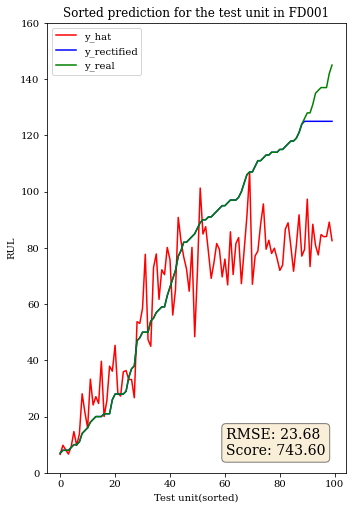

In [270]:
textstr = '\n'.join((    
    r'RMSE: %.2f' % (rmse, ),
    r'Score: %.2f' % (res, )))

# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

fig, ax1 = plt.subplots(figsize=(5, 7))

ax1.set_xlabel('Test unit(sorted)')
ax1.set_ylabel('RUL')
ax1.set_ylim([0, 160])
ax1.plot(df1['y_hat'], color='red', label='y_hat')
ax1.plot(df1['y'], color='blue', label='y_rectified')
ax1.plot(df1['y_real'], color='green', label='y_real')
ax1.legend()
ax1.text(0.60, 0.1, textstr, transform=ax1.transAxes, fontsize=14, verticalalignment='top', bbox=props)

fig.tight_layout()
plt.title('Sorted prediction for the test unit in ' + dataset)
plt.show()

In [271]:
df_type['y_hat_t2'] = df1['y_hat']

# Type3 Modeling: 열화시작 - 1~29개 threshold

In [272]:
# type2 modeling
x_train = x_train_f3
y_train = y_train_f3
x_valid = x_valid_f3
y_valid = y_valid_f3

In [273]:
x_train_re = x_train.reshape(x_train.shape[0], x_train.shape[1]*x_train.shape[2])
y_train_re = y_train.reshape(y_train.shape[0], y_train.shape[1]*y_train.shape[2])
x_valid_re = x_valid.reshape(x_valid.shape[0], x_valid.shape[1]*x_valid.shape[2])
y_valid_re = y_valid.reshape(y_valid.shape[0], y_valid.shape[1]*y_valid.shape[2])
x_train_re.shape

(2241, 150)

In [274]:
## ----------------------------------------------------------------------------
## Make model
window_size = sequence_length
input_dim = len(sensors)
output_dim = 1 # RUL

timeseries = x_train
batch_size = 512
insample_size = window_size * input_dim # 30 * 5
outsample_size = window_size * output_dim # 30 * 1
theta_size = insample_size + outsample_size
stacks = 3
layers = 4
layer_size = 1024
early_stop = 10


model = NBeats(t.nn.ModuleList([NBeatsBlock(input_size=insample_size,
                                            theta_size=theta_size,
                                            basis_function=GenericBasis(backcast_size = insample_size,
                                                                        forecast_size = outsample_size),
                                            layers=layers,
                                            layer_size=layer_size)
                                for _ in range(stacks)]))


default_device = t.device('cuda' if t.cuda.is_available() else 'cpu')
model = model.to(default_device)

learning_rate = 0.00001
optimizer = t.optim.Adam(model.parameters(), lr=learning_rate)
training_loss_fn = t.nn.MSELoss()
iterations = 10000
lr_decay_step = iterations // 3            
if lr_decay_step == 0:
    lr_decay_step = 1

In [275]:
# standby dataset
train_dataset = TensorDataset(t.Tensor(x_train_re), t.Tensor(y_train_re))
train_dataloader =  DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

valid_dataset = TensorDataset(t.Tensor(x_valid_re), t.Tensor(y_valid_re))
valid_dataloader =  DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)

his_train = []
min_valid_loss = 99999
cnt_valid_loss = 0
for i in range(1, iterations + 1):
    # Sampling
    x_train_sampled, y_train_sampled = next(iter(train_dataloader))

    # train
    model.train()
    x = x_train_sampled
    x_mask = np.ones(shape=x.shape, dtype=np.float32)
    y = y_train_sampled
    y_mask = np.ones(shape=y.shape, dtype=np.float32)    
    
    x, x_mask, y, y_mask = map(to_tensor, (x, x_mask, y, y_mask))

    optimizer.zero_grad() # init gradients before back-propagation
    forecast = model(x, x_mask)
    training_loss = training_loss_fn(forecast, y)

    if np.isnan(float(training_loss)):
        break

    training_loss.backward()
    t.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    optimizer.step()

    for param_group in optimizer.param_groups:
        param_group["lr"] = learning_rate * 0.5 ** (i // lr_decay_step)

    def check_directorys(f: str) -> None:
        if not Path(f).is_dir():
            print(f"create directory: {f.split(sep='/')[-1]}")
            Path(f).mkdir(parents=True, exist_ok=True)
            

    if i % 100 == 1:
        # Sampling
        x_valid_sampled, y_valid_sampled = next(iter(valid_dataloader))

        # valid
        model.eval()
        x = x_valid_sampled
        x_mask = np.ones(shape=x.shape, dtype=np.float32)
        y = y_valid_sampled
        y_mask = np.ones(shape=y.shape, dtype=np.float32)   

        x, x_mask, y, y_mask = map(to_tensor, (x, x_mask, y, y_mask))

        forecast = model(x, x_mask)
        valid_loss = training_loss_fn(forecast, y)

        f = r'./steps/' + dataset + r'/'
        check_directorys(f)
        f += f'weight_iter_{i:05d}.pth'
        print('Save Model:', f)
        t.save(model, f)
        print(f'iter:{i}/{iterations} \t train_loss:{training_loss:.3f} \t val_loss:{valid_loss:.3f}') 
        his_train.append([i, training_loss, valid_loss])

        if valid_loss < min_valid_loss:
            min_valid_loss = valid_loss
            cnt_valid_loss = 0
            best_model = copy.deepcopy(model)
        else:
            cnt_valid_loss += 1

        if cnt_valid_loss >= early_stop:
            print('Early stop..!!')
            print('Save Best Model')
            t.save(best_model, r'./steps/' + dataset + r'/best_weight.pth')
            break

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.


Save Model: ./steps/FD001/weight_iter_00001.pth
iter:1/10000 	 train_loss:14137.891 	 val_loss:14283.259
Save Model: ./steps/FD001/weight_iter_00101.pth
iter:101/10000 	 train_loss:13992.144 	 val_loss:13943.428
Save Model: ./steps/FD001/weight_iter_00201.pth
iter:201/10000 	 train_loss:4651.877 	 val_loss:4683.194
Save Model: ./steps/FD001/weight_iter_00301.pth
iter:301/10000 	 train_loss:1682.360 	 val_loss:1756.166
Save Model: ./steps/FD001/weight_iter_00401.pth
iter:401/10000 	 train_loss:173.389 	 val_loss:221.097
Save Model: ./steps/FD001/weight_iter_00501.pth
iter:501/10000 	 train_loss:54.048 	 val_loss:81.862
Save Model: ./steps/FD001/weight_iter_00601.pth
iter:601/10000 	 train_loss:39.926 	 val_loss:62.484
Save Model: ./steps/FD001/weight_iter_00701.pth
iter:701/10000 	 train_loss:31.629 	 val_loss:50.185
Save Model: ./steps/FD001/weight_iter_00801.pth
iter:801/10000 	 train_loss:27.803 	 val_loss:46.386
Save Model: ./steps/FD001/weight_iter_00901.pth
iter:901/10000 	 train_

In [276]:
# Evaluate
x_mask = np.ones(shape=x_test_re.shape, dtype=np.float32)
x, x_mask = map(to_tensor, (x_test_re, x_mask))

model = best_model
model.eval()
forecasts = []
with t.no_grad():
    forecasts.extend(model(x, x_mask).cpu().detach().numpy())   

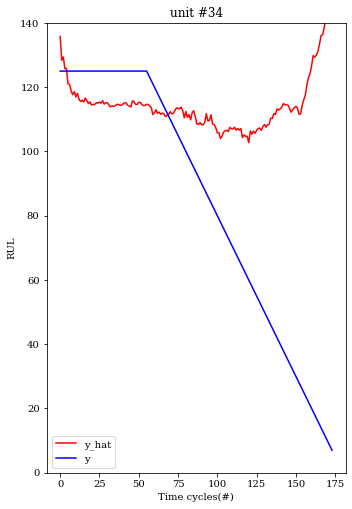

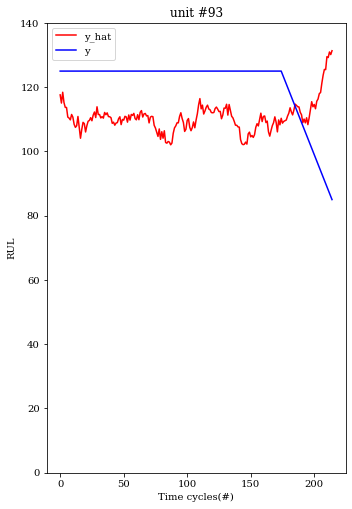

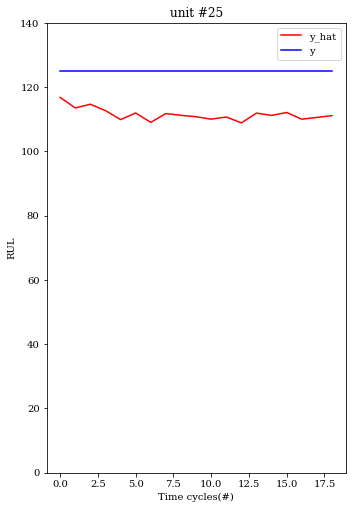

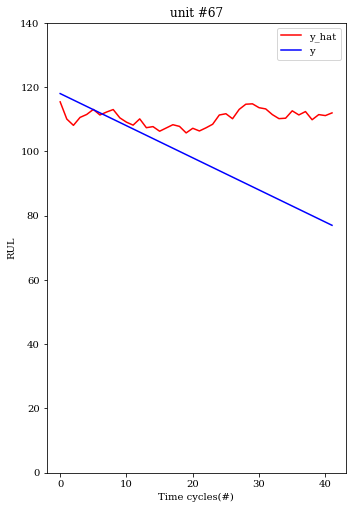

In [277]:
for n in [34, 93, 25, 67]:
    plot_unit(unit_no = n, forecasts = forecasts)

In [278]:
lst_y_true=[]
lst_y_hat=[]
for u in range(1, 101):   
    idx = x_test_index_re2[u-1][1]-1
    test = lambda v:threshold if v>threshold else v

    lst_y_true.append(int(test(y_test[:][:][u-1][window_size-1])))
    lst_y_hat.append(forecasts[idx][window_size-1])

rmse, var = evaluate(lst_y_true, lst_y_hat)
res = score(lst_y_true, lst_y_hat)

test set RMSE:69.595, R2:-2.016
score: 94853713.159


In [279]:
df1 = pd.DataFrame(lst_y_true, columns=['y'])
df1['y_hat'] = pd.DataFrame(lst_y_hat)
df1['y_real'] = pd.DataFrame([int(x[-1]) for x in y_test])
df1 = df1.sort_values(by=['y_real']).reset_index()

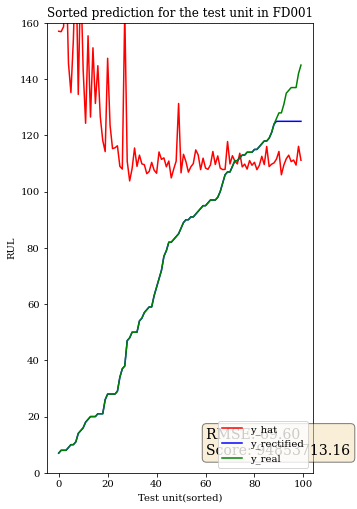

In [280]:
textstr = '\n'.join((    
    r'RMSE: %.2f' % (rmse, ),
    r'Score: %.2f' % (res, )))

# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

fig, ax1 = plt.subplots(figsize=(5, 7))

ax1.set_xlabel('Test unit(sorted)')
ax1.set_ylabel('RUL')
ax1.set_ylim([0, 160])
ax1.plot(df1['y_hat'], color='red', label='y_hat')
ax1.plot(df1['y'], color='blue', label='y_rectified')
ax1.plot(df1['y_real'], color='green', label='y_real')
ax1.legend()
ax1.text(0.60, 0.1, textstr, transform=ax1.transAxes, fontsize=14, verticalalignment='top', bbox=props)

fig.tight_layout()
plt.title('Sorted prediction for the test unit in ' + dataset)
plt.show()

In [281]:
df_type['y_hat_t3'] = df1['y_hat']
df_type.rename(columns={'y_hat':'y_hat_t1'})
df_type.head()

,index,y,y_hat,y_real,y_hat_t2,y_hat_t3
0,33,7,222.080444,7,6.569926,157.030380
1,67,8,222.615463,8,9.798528,156.875229
2,30,8,231.116058,8,8.209951,158.658585
3,80,8,255.613983,8,6.657054,181.345230
4,81,9,193.005447,9,9.234745,145.621262
